In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

훈련 중에 문제가 일어날 수 있다..

- **그레이디언트 소실** 또는 **그레이디언트 폭주**
- 훈련데이터 부족 혹은 레이블 만드는 작업의 비용과다
- 훈련이 느려질 수 있음
- 과대적합 문제...

이의 해결방안을 살펴보자..

#11.1 그레이디언트 소실과 폭주 문제

- 역전파 알고리즘은 출력층에서 입력층으로 오차 그레이디언트를 전파하며 진행된다
- 하위층으로 진행될수록 그레이디언트가 점점 작아지는 경우가 많다.(소실)
- 혹은 엄청 커진다 (폭주)

In [2]:
def logit(z):
    return 1 / (1 + np.exp(-z))

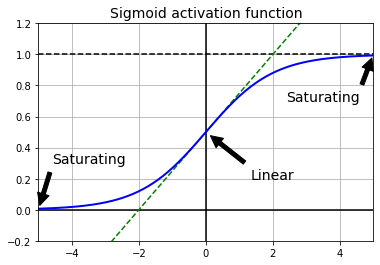

In [3]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

시그모이드의 도함수 : $\sigma(1-\sigma)$

- 입력이 커지면 시그모이드 값이 0이나 1로 스렴하게 되고, 기울기가 0에 매우 가까워진다
- 사실상 학습할 그레이디언트가 하위층으로 가면 없어진다..

##11.1.1 글로럿과 He 초기화

**방법**

- 정방향 역방향 모두 신호가 적절하게 흘러야한다.
- 1) **각 층의 출력에 대한 분산이 입력에 대한 분산과 같아야한다**
- 2) **역방향에서 층을 통과하기 전과 후의 그레이디언트 분산이 동일해야한다**
- 위 1), 2)를 보장하려면 층의 입력과 출력 연결 갯수가 같아야 한다!

**르쿤 초기화**

- 층의 입력을 기준으로 분산을 지정

**글로럿 초기화** (기본값)

- 층의 입력과 출력연결 갯수의 평균을 기준으로 분산을 지정

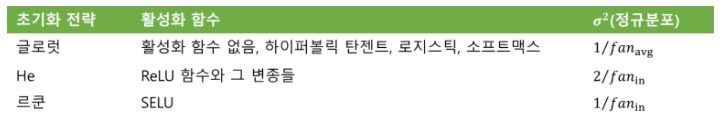

In [4]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

In [5]:
he_avg_init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg', distribution='uniform')
keras.layers.Dense(10, activation="sigmoid", kernel_initializer=he_avg_init)

##11.1.2 수렴하지 않는 활성화 함수

활성화 함수도 잘 선택해야함..

###ReLU
- 특정 양숫값에 수렴하지 않는다는 것이 큰 장점.. 계산도 빠름..
- 가중치 합이 음수이면 그레이디언트를 0으로 만들어 더이상 경사하강법이 안 됨..

###LeakyReLU
- 새는 정도 $\alpha$ 지정.. (0보다 작을때의 기울기)
- 항상 그냥 ReLU보다는 성능이 좋음..
- $\alpha$ = 0.01 기본값

In [6]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

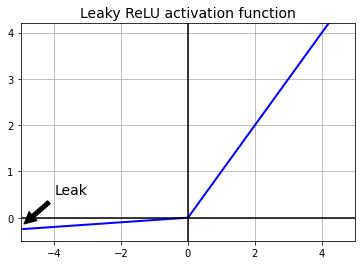

In [7]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

plt.show()

LeakyReLU를 사용한 패션 MNIST 신경망 학습..

In [8]:
#훈련 검증 테스트 세트 다 나눴고 스케일링까지 완료..

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

4431872/4422102 [==============================] - 0s 0us/step


In [9]:
#he초기화 하고 활성화함수로 LeakyReLU추가..

tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [10]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [11]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 1.2819 - accuracy: 0.6229 - val_loss: 0.8886 - val_accuracy: 0.7160
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7955 - accuracy: 0.7361 - val_loss: 0.7130 - val_accuracy: 0.7656
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6816 - accuracy: 0.7721 - val_loss: 0.6427 - val_accuracy: 0.7900
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6217 - accuracy: 0.7944 - val_loss: 0.5900 - val_accuracy: 0.8064
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5832 - accuracy: 0.8074 - val_loss: 0.5582 - val_accuracy: 0.8200
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5553 - accuracy: 0.8156 - val_loss: 0.5350 - val_accuracy: 0.8238
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5339 - accuracy: 0.8223 - val_loss: 0.5156 - val_accuracy:

###RReLU
- 훈련하는 동안 $\alpha$값을 주어진 범위에서 무작위 선택 후 테스트 시에는 평균을 사용..

###PReLU
- $\alpha$가 훈련하는 동안 학습됨..

패션 MNIST 신경망 PReLU 활성화 함수..

In [12]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [13]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [14]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 1.3461 - accuracy: 0.6209 - val_loss: 0.9255 - val_accuracy: 0.7186
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.8197 - accuracy: 0.7355 - val_loss: 0.7305 - val_accuracy: 0.7628
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6966 - accuracy: 0.7694 - val_loss: 0.6565 - val_accuracy: 0.7878
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6331 - accuracy: 0.7909 - val_loss: 0.6004 - val_accuracy: 0.8046
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5917 - accuracy: 0.8057 - val_loss: 0.5656 - val_accuracy: 0.8180
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5618 - accuracy: 0.8135 - val_loss: 0.5406 - val_accuracy: 0.8240
Epoch 7/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5390 - accuracy: 0.8206 - val_loss: 0.5196 - val_accuracy:

###ELU

- 얘가 모든 ReLU변종보다 더 좋았다
- 성능 및 시간 측면에서 모두..
- $\text{ELU}_\alpha(z) = \begin{cases} \alpha(\text{exp}(z) -1) & z < 0 \text{일 때} \\
z & z \ge 0 \text{일 때}
\end{cases}$

**ReLU와의 차이**

- z가 0보다 작을 때 음숫값이니까 평균 출력이 0에 더 가까워진다
- 음수일 때도 그레이디언트가 0이 아니라서 죽은 뉴런이 없다..
- 모든 구간에서 미분가능하다

In [15]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

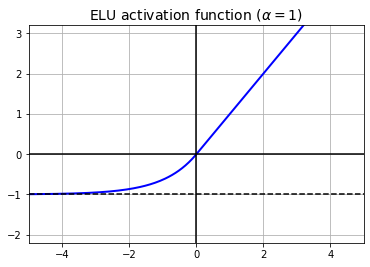

In [16]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

In [17]:
#층 만들면서 바로 지정 가능..

keras.layers.Dense(10, activation="elu")

###SELU

- 스케일이 조정된 ELU 활성화 함수의 변종
- **완전 연결층**만 쌓아서 신경망을 만들고 모든 은닉층이 SELU활성화 함수를 사용하면 네트워크가 **자기 정규화**됨
    - 배치정규화 불필요..
- 즉, 훈련하는 동안 각 층의 출력이 평균 0, 표준편차 1을 유지..

**조건**

- 입력특성이 반드시 표준화 되어야함
- 모든 은닉층의 가중치가 **르쿤 초기화**되어야함
- 모든 네트워크가 순차적으로 쌓아야함..

In [18]:
from scipy.special import erfc

# alpha와 scale은 평균 0과 표준 편차 1로 자기 정규화합니다
# (논문에 있는 식 14 참조):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [19]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

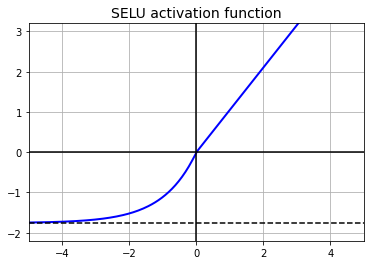

In [20]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

실제로 모든 층에서 출력이 평균 0, 표준편차 1을 유지하려고 하는 모습..

In [21]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # 표준화된 입력
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun 초기화
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


In [22]:
#SELU도 그냥 층만들면서 바로 하면 되고, 르쿤초기화는 꼭 해야함

keras.layers.Dense(10, activation="selu", kernel_initializer="lecun_normal")

SELU를 이용한 패션 MNIST 신경망..

In [23]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [24]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [25]:
#훈련시 입력이 모두 표준화되어 있어야함!!

pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)

#표준화..
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [26]:
#훈련..
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 32s 17ms/step - loss: 1.3776 - accuracy: 0.4540 - val_loss: 1.1731 - val_accuracy: 0.5614
Epoch 2/5
1719/1719 [==============================] - 29s 17ms/step - loss: 0.9138 - accuracy: 0.6665 - val_loss: 0.7028 - val_accuracy: 0.7484
Epoch 3/5
1719/1719 [==============================] - 29s 17ms/step - loss: 0.6962 - accuracy: 0.7481 - val_loss: 0.6540 - val_accuracy: 0.7546
Epoch 4/5
1719/1719 [==============================] - 28s 17ms/step - loss: 0.6539 - accuracy: 0.7676 - val_loss: 0.5557 - val_accuracy: 0.7978
Epoch 5/5
1719/1719 [==============================] - 28s 16ms/step - loss: 0.5582 - accuracy: 0.7990 - val_loss: 0.5703 - val_accuracy: 0.8016


만약 ReLU였다면..??

In [27]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [28]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [29]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 29s 15ms/step - loss: 1.8261 - accuracy: 0.2616 - val_loss: 1.3347 - val_accuracy: 0.3894
Epoch 2/5
1719/1719 [==============================] - 26s 15ms/step - loss: 1.1959 - accuracy: 0.4908 - val_loss: 0.9373 - val_accuracy: 0.5902
Epoch 3/5
1719/1719 [==============================] - 26s 15ms/step - loss: 0.9600 - accuracy: 0.6118 - val_loss: 0.9026 - val_accuracy: 0.5906
Epoch 4/5
1719/1719 [==============================] - 26s 15ms/step - loss: 0.8231 - accuracy: 0.6759 - val_loss: 0.7320 - val_accuracy: 0.7290
Epoch 5/5
1719/1719 [==============================] - 26s 15ms/step - loss: 0.7360 - accuracy: 0.7171 - val_loss: 0.7823 - val_accuracy: 0.7108


##11.1.3 배치 정규화

 - 입력을 원점에 맞추고 정규화한 뒤, 각 층에서 두 개의 새로운 파라미터로 결과값의 스케일을 조정하고 이동..

**훈련 시 알고리즘**

1. $\mu_B = \dfrac{1}{m_B}\sum\limits_{i=1}^{m_B}\mathbf{x}^{(i)}$
- 미니 배치마다 입력의 평균을 계산

2. $\sigma_B^2 = \dfrac{1}{m_B}\sum\limits_{i=1}^{m_B}(\mathbf{x}^{(i)}-\mu_B)^2$
- 미니 배치마다 입력의 표준편차 계산

3. $\hat{\mathbf{x}}^{(i)} = \dfrac{\mathbf{x}^{(i)} - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}$
- 정규화 시행 (스케일링)
- 분모가 0이 되지 않도록 $\epsilon$을 더해줌..

4. $\mathbf{z}^{(i)} = \gamma * \hat{\mathbf{x}}^{(i)} + \beta$
- 출력을 이동..
- 스케일 파라미터들..
- $\beta$ : 어디 중심일지..
- $\gamma$ : 얼만큼 뿌릴지..

**테스트 시에는??**

- 하나의 샘플에 대해서 해야하므로 일단 평균, 표준편차를 할 수가 없다..
- 그래서 훈련할 때 얻었던 미니 배치마다의 평균, 분산이 있었다,. 그것들의 평균을 사용하겠다!!
- $\mu$ : 평균의 평균
- $\sigma$ : 분산의 평균..
    - 둘다 non-trainable..
- 미니배치가 $m_B$개 이면, 분산에는 $\dfrac{m_B}{m_B-1}$을 곱한다..

**개념 정리**

- 미니배치마다 입력의 평균과 표준편차 조사..
- 입력을 모두 정규화 해서 스케일 파라미터 $\gamma, \beta$를 이용해 배치 정규화 연산 수행..
- $\beta$에 의해서 편향을 다시 학습하므로 training 층에서 편향을 학습 안해도 됨..
- 총 매개변수 4개.. -> trainable은 2개..

### 케라스로 배치 정규화 구현하기

In [30]:
#층의 뒤에 배치정규화 층 삽입..

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation='elu', kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation='elu', kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation='softmax')
])

In [31]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense_212 (Dense)            (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_213 (Dense)            (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_214 (Dense)            (None, 10)               

- 배치 정규화 층에서 입력마다 네 개의 파라미터 $\gamma, \beta, \mu, \sigma$를 학습한다..

- $\mu, \sigma$는 이동평균이고, 역전파로 학습되지 않으므로 Non-trainable 파라미터로 분류된다..
    - Non-trainable params : 2 * (784 + 300 + 100) = 2368

In [32]:
#Non-trainable params확인..
#이동평균, 이동표준편차는 추정되는 것.. -> Non-trainable..

[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [33]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [34]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.9021 - accuracy: 0.6946 - val_loss: 0.6012 - val_accuracy: 0.8004
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.6103 - accuracy: 0.7904 - val_loss: 0.5175 - val_accuracy: 0.8240
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5540 - accuracy: 0.8078 - val_loss: 0.4802 - val_accuracy: 0.8354
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5171 - accuracy: 0.8212 - val_loss: 0.4558 - val_accuracy: 0.8454
Epoch 5/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4936 - accuracy: 0.8275 - val_loss: 0.4398 - val_accuracy: 0.8492
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4771 - accuracy: 0.8339 - val_loss: 0.4274 - val_accuracy: 0.8520
Epoch 7/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4641 - accuracy: 0.8384 - val_loss: 0.4155 - val_accuracy:

BN층을 층 앞에 해도 됨.. 그럼 편향을 위한 항이 필요가 없음..

In [35]:
#BN층이 앞에 있는 경우..
#use_bias = False 지정..

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])

##11.1.4 그레이디언트 클리핑


일정 임곗값을 넘어서지 못하게 그레이디언트를 잘라내는 것..

**두가지 방법이 있음..**

1. 그레이디언트 방향 변화..

    ex) [0.9, 100.0] -> [0.9, 1.0]

2. 그레이디언트 방향 변화 없음..

    ex) [0.9, 100.0] -> [0.00899..., 0.9999..]


In [36]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)
model.compile(loss="mse", optimizer=optimizer)

#11.2 사전훈련된 층 재사용하기

**전이학습**

- 비슷한 유형의 문제를 처리한 신경망의 하위층을 재사용하는 방법..
- 몇 개의 층을 재사용할지 반복해서 찾아야한다..

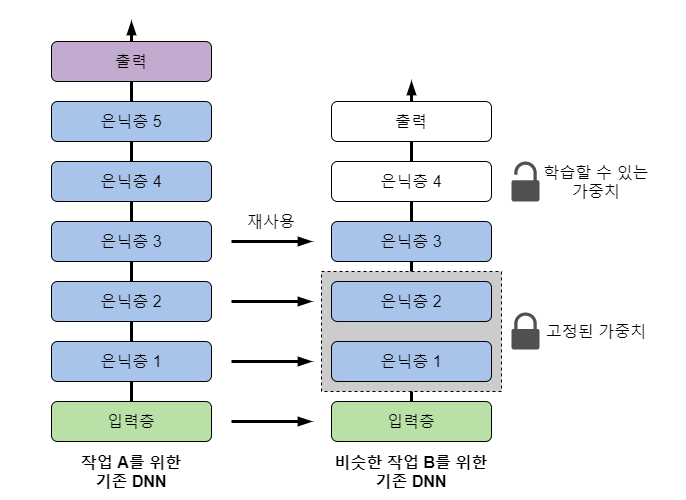

##11.2.1 케라스를 사용한 전이 학습

모델 A : 8개의 클래스를 분류하는 모델..

모델 B : 샌들과 셔츠 이미지를 이진 분류하는 모델..


###데이터 준비

- X_train_A : 샌달과 셔츠를 제외한 모든 이미지
- X_train_B : 샌달과 셔츠 이미지 중 처음 200개만..

In [37]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)

#처음 200개..
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [38]:
X_train_A.shape

(43986, 28, 28)

In [39]:
X_train_B.shape

(200, 28, 28)

In [40]:
y_train_A[:30]

array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4, 0, 1, 6, 3, 4, 3, 2, 6, 5, 3, 4, 5,
       1, 3, 4, 2, 0, 6, 7, 1], dtype=uint8)

In [41]:
#이진 분류기의 레이블..

y_train_B[:30]

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.], dtype=float32)

###모델 A 생성 및 훈련

In [42]:
tf.random.set_seed(42)
np.random.seed(42)

model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))

#밀집층 5개 추가..
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [43]:
model_A.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_218 (Dense)            (None, 300)               235500    
_________________________________________________________________
dense_219 (Dense)            (None, 100)               30100     
_________________________________________________________________
dense_220 (Dense)            (None, 50)                5050      
_________________________________________________________________
dense_221 (Dense)            (None, 50)                2550      
_________________________________________________________________
dense_222 (Dense)            (None, 50)                2550      
_________________________________________________________________
dense_223 (Dense)            (None, 8)                

In [44]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

In [45]:
#훈련..

history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 5s 3ms/step - loss: 0.5927 - accuracy: 0.8104 - val_loss: 0.3896 - val_accuracy: 0.8667
Epoch 2/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.3523 - accuracy: 0.8786 - val_loss: 0.3289 - val_accuracy: 0.8824
Epoch 3/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.3170 - accuracy: 0.8896 - val_loss: 0.3014 - val_accuracy: 0.8989
Epoch 4/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.2973 - accuracy: 0.8975 - val_loss: 0.2894 - val_accuracy: 0.9021
Epoch 5/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.2835 - accuracy: 0.9022 - val_loss: 0.2776 - val_accuracy: 0.9066
Epoch 6/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.2729 - accuracy: 0.9061 - val_loss: 0.2735 - val_accuracy: 0.9071
Epoch 7/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.2641 - accuracy: 0.9093 - val_loss: 0.2720 - val_accuracy:

In [46]:
#저장..

model_A.save("my_model_A.h5")

### 모델 B 생성 및 훈련

In [47]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))

#은닉층 5개 추가..
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

In [48]:
model_B.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_224 (Dense)            (None, 300)               235500    
_________________________________________________________________
dense_225 (Dense)            (None, 100)               30100     
_________________________________________________________________
dense_226 (Dense)            (None, 50)                5050      
_________________________________________________________________
dense_227 (Dense)            (None, 50)                2550      
_________________________________________________________________
dense_228 (Dense)            (None, 50)                2550      
_________________________________________________________________
dense_229 (Dense)            (None, 1)                

In [49]:
model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

In [50]:
#훈련

history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
7/7 [==============================] - 1s 38ms/step - loss: 0.9573 - accuracy: 0.4650 - val_loss: 0.6314 - val_accuracy: 0.6004
Epoch 2/20
7/7 [==============================] - 0s 16ms/step - loss: 0.5692 - accuracy: 0.7450 - val_loss: 0.4784 - val_accuracy: 0.8529
Epoch 3/20
7/7 [==============================] - 0s 15ms/step - loss: 0.4503 - accuracy: 0.8650 - val_loss: 0.4102 - val_accuracy: 0.8945
Epoch 4/20
7/7 [==============================] - 0s 17ms/step - loss: 0.3879 - accuracy: 0.8950 - val_loss: 0.3647 - val_accuracy: 0.9178
Epoch 5/20
7/7 [==============================] - 0s 16ms/step - loss: 0.3435 - accuracy: 0.9250 - val_loss: 0.3300 - val_accuracy: 0.9320
Epoch 6/20
7/7 [==============================] - 0s 13ms/step - loss: 0.3081 - accuracy: 0.9300 - val_loss: 0.3019 - val_accuracy: 0.9402
Epoch 7/20
7/7 [==============================] - 0s 13ms/step - loss: 0.2800 - accuracy: 0.9350 - val_loss: 0.2804 - val_accuracy: 0.9422
Epoch 8/20
7/7 [===========

###전이 학습을 해보자.. (A로 부터..)

In [51]:
model_A = keras.models.load_model("my_model_A.h5")

#A 모델에서 출력층 빼고 가져와서
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
#출력층만 추가해서 새로운 모델 만듦..
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

In [52]:
#clone_model()메서드로 가중치 복사..

model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

In [53]:
#재사용한 층을 동결한다..(출력층 말고..)
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])

처음 몇번의 에포크 동안 재사용 층을 동결해서 새로운 층에 적절한 가중치를 학습할 시간을 줌..

In [54]:
#4번의 에포크 동안 동결..
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

#동결 해제..
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

#다시 컴파일 필수..
model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])

#남은 16번의 에포크 시행..
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 1s 34ms/step - loss: 0.5728 - accuracy: 0.6550 - val_loss: 0.5777 - val_accuracy: 0.6389
Epoch 2/4
7/7 [==============================] - 0s 14ms/step - loss: 0.5370 - accuracy: 0.6850 - val_loss: 0.5409 - val_accuracy: 0.6836
Epoch 3/4
7/7 [==============================] - 0s 12ms/step - loss: 0.5008 - accuracy: 0.7300 - val_loss: 0.5094 - val_accuracy: 0.7130
Epoch 4/4
7/7 [==============================] - 0s 15ms/step - loss: 0.4699 - accuracy: 0.7500 - val_loss: 0.4812 - val_accuracy: 0.7343
Epoch 1/16
7/7 [==============================] - 1s 37ms/step - loss: 0.3926 - accuracy: 0.8200 - val_loss: 0.3436 - val_accuracy: 0.8661
Epoch 2/16
7/7 [==============================] - 0s 16ms/step - loss: 0.2780 - accuracy: 0.9350 - val_loss: 0.2591 - val_accuracy: 0.9280
Epoch 3/16
7/7 [==============================] - 0s 16ms/step - loss: 0.2073 - accuracy: 0.9650 - val_loss: 0.2103 - val_accuracy: 0.9554
Epoch 4/16
7/7 [===============

테스트 점수는..??

In [55]:
model_B.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 2ms/step - loss: 0.1408 - accuracy: 0.9705


[0.1408407837152481, 0.9704999923706055]

In [56]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 2ms/step - loss: 0.0682 - accuracy: 0.9930


[0.06824079155921936, 0.9929999709129333]

졸라 좋아지긴 했는데, 너무 좋아졌으면 근데 일단 의심은 해봐야한다!!
- 데이터 들들 볶기 시전했을 수도 있음..

##11.2.2 비지도 사전훈련

##11.2.3 보조 작업에서 사전훈련

#11.3 고속 옵티마이저

##11.3.1 모멘텀 최적화

- 이전 그레이디언트가 얼마였는지를 상당히 중요하게 생각!
- 즉, 그레이디언트를 속도가 아니라 **가속도로 사용**
- 일반 경사하강법보다 더 빠르게 최솟값을 찾게해줌.. -> 지역최저점을 건너뛰는데도 좋음!

**알고리즘**

1. $\mathbf{m} = \beta\mathbf{m} - \eta\nabla_{\theta}\mathbf{J}(\theta)$
- m에다가 현재 그레이디언트를 뺀다..
- $\beta$ : 모멘텀이 너무 커지는 것을 막기위한 **모멘텀..** 일반적으로 기본값은 0.9

2. $\theta = \theta + \mathbf{m}$

In [57]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

##11.3.2 네스테로프 가속 경사

- 모멘텀의 변종.. 무조건 모멘텀보다는 빠름..
- 현재위치가 아니라 모멘텀의 방향으로 조금 앞선 곳에서의 비용함수의 그레이디언트를 계산한다..

**알고리즘**

1. $\mathbf{m} = \beta\mathbf{m} - \eta\nabla_{\theta}\mathbf{J}(\theta + \beta\mathbf{m})$

2. $\theta = \theta + \mathbf{m}$

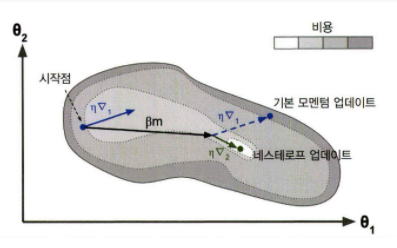

In [58]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

##11.3.3 AdaGrad

- 가장 가파를 차원을 따라 그레이디언트 벡터의 스케일을 감소시키는 방법..
- **가중치마다 학습률이 다르게 적용됨!**

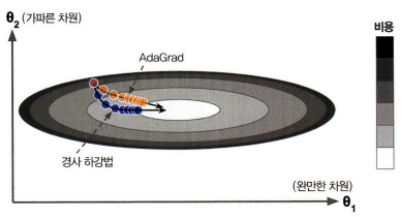

**알고리즘**

1. $\mathbf{s} = s + \nabla_{\theta}\mathbf{J}(\theta) * \nabla_{\theta}\mathbf{J}(\theta)$
- 그레이디언트의 제곱을 벡터 $s$에 누적한다..
- 즉, $s_i$는 파라미터 $\theta_i$에 대한 비용함수의 편미분을 제곱하여 누적한 것..

2. $\theta = \theta - \eta\nabla_{\theta}\mathbf{J}(\theta) / \sqrt{s+\epsilon}$
- 경사하강법과 같고, $\sqrt{s+\epsilon}$으로 나누어서 스케일링 한다는 것만 다르다..

**요약**

- 학습률을 감소시키지만, 경사가 가파를 차원에 대해 더 빠르게 감소된다
- 이를 **적응적 학습률**이라고 한다..
- 학습률이 너무 감소되어 전역 최적점에 도착하기 전에 알고리즘이 멈출수도 있다..

In [59]:
optimizer = keras.optimizers.Adagrad(learning_rate=0.001)

##11.3.4 RMSProp

- 가장 최근 반복에서 비롯된 그레이디언트만 누적함.. (AdaGrad의 문제 해결)

**알고리즘**

1. $\mathbf{s} = \beta s + (1-\beta)\nabla_{\theta}\mathbf{J}(\theta) * \nabla_{\theta}\mathbf{J}(\theta)$
- $\beta$로 얼마나 최근거만 누적할지 확인..

2. $\theta = \theta - \eta\nabla_{\theta}\mathbf{J}(\theta) / \sqrt{s+\epsilon}$

**요약**

- AdaGrad에서 $\beta$ 파라미터만 추가된 것이다..

In [60]:
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

##11.3.5 Adam과 Nadam 최적화

###Adam

- 모멘텀 + RMSProp

**알고리즘**


1. $\mathbf{m} = \beta_1\mathbf{m} -(1-\beta_1)\nabla_{\theta}\mathbf{J}(\theta)$
    - 지수감소..

2. $\mathbf{s} = \beta_2 s + (1-\beta_2)\nabla_{\theta}\mathbf{J}(\theta) * \nabla_{\theta}\mathbf{J}(\theta)$
    - 지수감소..

3. $\hat{\mathbf{m}} = \dfrac{\mathbf{m}}{1-\beta_1^t}$

4. $\hat{\mathbf{s}} = \dfrac{\mathbf{s}}{1-\beta_2^t}$
    - 3, 4 모두 해당..
    - 반복 초기에는 $\mathbf{m}, \mathbf{s}$가 0으로 초기화되어서 0으로 치우치는데,
    - 이를 보상하기위해서 3,4 단계가 m, s를 증폭시킴..
    - 반복이 지날수록 $\beta_1^t, \beta_2^t$가 0에 가까워져 증폭효과가 감소..

5. $\theta = \theta - \eta \hat{\mathbf{m}} / \sqrt{s+\epsilon}$
    - RMSProp과 비슷..

In [61]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

###옵티마이저 정리..

- 최적화 이론은 1,2차 편미분에 의해서도 다 논의 할 수 있다..
- 근데 2차 편미분(헤시안)은 너무 비용이 많이 든다..

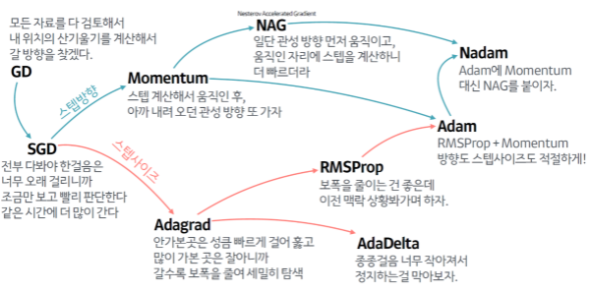

##11.3.6 학습률 스케쥴링

- 좋은 학습률을 찾는것은 매우 중요!!
- 큰 학습률에서 시작해서 학습 속도가 느려질때 학습률을 낮추면 좋은 솔루션을 찾을 수 있다!! (**학습 스케쥴**)

###거듭제곱 스케줄링

- 옵티마이저 생성할때 decay 매개변수만 지정해주면 구현할 수 있음..
- 초기 학습률 $\eta_0$, 스텝횟수 s ( = decay의 역수) 로 지정..
- 학습률이 각 스텝마다 감소됨..
    - 갈수록 천천히 감소됨..
- s 스텝이후 $\eta_0$/2, s스텝이후 $\eta_0$/3, ...

In [62]:
#decay 매개변수 지정으로 구현..

optimizer = keras.optimizers.SGD(learning_rate=0.01, decay=1e-4)

In [63]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [64]:
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4855 - accuracy: 0.8303 - val_loss: 0.4031 - val_accuracy: 0.8596
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3781 - accuracy: 0.8655 - val_loss: 0.3715 - val_accuracy: 0.8722
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3457 - accuracy: 0.8770 - val_loss: 0.3744 - val_accuracy: 0.8740
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3250 - accuracy: 0.8831 - val_loss: 0.3502 - val_accuracy: 0.8802
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3102 - accuracy: 0.8892 - val_loss: 0.3450 - val_accuracy: 0.8782
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2966 - accuracy: 0.8934 - val_loss: 0.3417 - val_accuracy: 0.8816
Epoch 7/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2868 - accuracy: 0.8973 - val_loss: 0.3361 - val_accuracy:

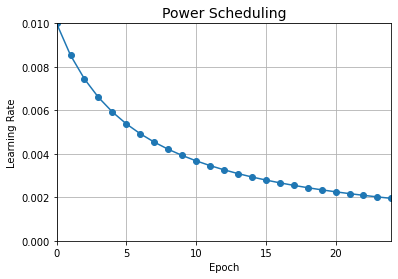

In [65]:
#각 에포크에서 학습률 확인..
import math

learning_rate = 0.01
decay = 1e-4
batch_size = 32

#에포크마다 몇 스텝잇는지..
n_steps_per_epoch = math.ceil(len(X_train) / batch_size)
#에포크 리스트 생성.. (0 - 24)
epochs = np.arange(n_epochs)
#학습률 계산.. (브로드캐스팅)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

###지수 기반 스케줄링

- 학습률이 s스텝마다 10배씩 점차 줄어듦..
- 시간이 지나도 일정하게 학습률이 줄어듦..

In [66]:
#학습률 반환하는 함수..
#하드코딩 외어있음..

def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

In [67]:
#하드코딩 안하려면 매개변수 지정..
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [68]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

In [69]:
#스케쥴링 함수를 전달해서 콜백으로 전달..
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.8781 - accuracy: 0.7523 - val_loss: 1.0124 - val_accuracy: 0.7638
Epoch 2/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.7191 - accuracy: 0.7834 - val_loss: 0.6600 - val_accuracy: 0.8048
Epoch 3/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.6239 - accuracy: 0.8085 - val_loss: 0.6343 - val_accuracy: 0.8300
Epoch 4/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5745 - accuracy: 0.8262 - val_loss: 0.5104 - val_accuracy: 0.8410
Epoch 5/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5296 - accuracy: 0.8400 - val_loss: 0.5630 - val_accuracy: 0.8400
Epoch 6/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4947 - accuracy: 0.8509 - val_loss: 0.5418 - val_accuracy: 0.8582
Epoch 7/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4610 - accuracy: 0.8602 - val_loss: 0.5641 - val_ac

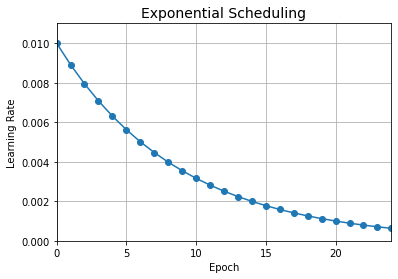

In [70]:
#학습률을 그려보자..

plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

In [71]:
#이렇게 구현하면 학습률도 같이 저장된다..
def exponential_decay_fn(epoch, lr):
    return lr * 0.1**(1 / 20)

###구간별 고정 스케줄링

- 일정횟수의 에포크동안 일정한 학습률 사용..

In [72]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

##성능기반 스케줄링

- 매 N스텝마다 검증오차를 측정하고 오차가 줄어들지 않으면 $\lambda$배 만큼 학습률을 감소시킴

In [73]:
#0.5배씩 줄인다.. 5번 참는다..

lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

#11.4 규제를 사용해 과대적합 피하기

- 파라미터 수가 많은 만큼 과대적합 되기 쉽다..

##11.4.1 $l_1$과 $l_2$ 규제

In [74]:
layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           #l2 규제 강도를 지정해줌..
                           kernel_regularizer=keras.regularizers.l2(0.01))

In [75]:
#규제가 포함된 층을 가지는 모델 생성..

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)), #규제
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)), #규제
    keras.layers.Dense(10, activation="softmax",
                       kernel_regularizer=keras.regularizers.l2(0.01))  #규제
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 12s 7ms/step - loss: 1.6203 - accuracy: 0.8137 - val_loss: 0.7131 - val_accuracy: 0.8344
Epoch 2/2
1719/1719 [==============================] - 12s 7ms/step - loss: 0.7171 - accuracy: 0.8293 - val_loss: 0.6802 - val_accuracy: 0.8410


위의 코드가 너무 더러워서 functools.partial() 함수를 사용해서 함수 호출을 감쌀수 있다..

In [76]:
from functools import partial

#요런 층을 함수로 만들어놓는다..
RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    #앞에서 만든 층 3개를 그냥 바로 씀.. 훨씬 깔끔!
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 12s 7ms/step - loss: 1.6736 - accuracy: 0.8109 - val_loss: 0.7208 - val_accuracy: 0.8320
Epoch 2/2
1719/1719 [==============================] - 11s 7ms/step - loss: 0.7189 - accuracy: 0.8277 - val_loss: 0.6823 - val_accuracy: 0.8378


##11.4.2 드롭아웃

- 랜덤으로 드롭아웃 시킴으로써 각 뉴런 모두가 실력있는 뉴런이 될 수 있도록 함!!
- 보존확률 생각해줘야 함..
- 과대적합이라면 드롭아웃 비율 늘리고, 반대라면 반대로..
- SELU 활성화함수를 써서 자기정규화를 하고 싶은데 드롭아웃도 하고싶으면 **알파드롭아웃**을 써라!

**알고리즘**

- **드롭아웃 비율** p를 지정
- 매 훈련 스텝에서 임의로 출력을 p만큼 버림..
- 근데 그러면 살아남은 뉴런은 더 많은 입력뉴런과 연결됨..
- 이를 되돌리기 위해 **보존 확률** (1-p)를 곱해야함!!

In [77]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 11s 6ms/step - loss: 0.5738 - accuracy: 0.8048 - val_loss: 0.3526 - val_accuracy: 0.8702
Epoch 2/2
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4184 - accuracy: 0.8466 - val_loss: 0.3512 - val_accuracy: 0.8656


##11.4.3 몬테 카를로 드롭아웃

- 일반 드롭아웃보다 성능도 좋고 불확실성도 줄여준다..

MC 드롭아웃 구현..

In [78]:
tf.random.set_seed(42)
np.random.seed(42)

In [79]:
#100번의 테스트세트에 대해
#10000개의 샘플에 대한 10개의 클래스마다의 확률..
y_probas = np.stack([model(X_test_scaled, training=True)
                     for sample in range(100)])

#평균.. 표준편차..
y_proba = y_probas.mean(axis=0)
y_std = y_probas.std(axis=0)

In [80]:
y_probas.shape, y_proba.shape, y_std.shape

((100, 10000, 10), (10000, 10), (10000, 10))

In [81]:
#드롭아웃 한 결과.. -> 더 안정적..

np.round(model.predict(X_test_scaled[:1]), 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.24, 0.  , 0.75]],
      dtype=float32)

In [82]:
#드롭아웃 비활성화

np.round(y_probas[:, :1], 2)

array([[[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.45, 0.  , 0.53]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.65, 0.  , 0.34]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.  , 0.11, 0.  , 0.84]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.05, 0.  , 0.93]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.04, 0.  , 0.47, 0.  , 0.49]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.4 , 0.  , 0.59]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.23, 0.  , 0.76]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.25, 0.  , 0.43, 0.  , 0.32]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.48, 0.  , 0.52]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.23, 0.  , 0.76]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.01, 0.  , 0.96]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.06, 0.  , 0.62, 0.  , 0.32]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.14, 0.  , 0.22, 0.  , 0.64]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.04, 0.  , 0

In [83]:
#평균 낸 결과.. 
#드롭아웃 안하면 불안정함...

np.round(y_proba[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.  , 0.32, 0.  , 0.63]],
      dtype=float32)

In [84]:
#표준편차도 큰거 보니까 불안정하네..

y_std = y_probas.std(axis=0)
np.round(y_std[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.07, 0.  , 0.22, 0.  , 0.23]],
      dtype=float32)

In [85]:
#확률이 제일 높은걸로 예측 생성..

y_pred = np.argmax(y_proba, axis=1)

In [86]:
#정확도 확인..나쁘지 않은건가..??

accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy

0.8571

##11.4.4. 맥스-노름 규제

- 배치 정규화를 사용하지 않았을 때 불안정한 그레이디언트 문제를 완화하는데 도움을 줌..

In [87]:
layer = keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal",
                           kernel_constraint=keras.constraints.max_norm(1.))

#11.5 요약 및 실용적인 가이드라인

##기본 DNN 설정

커널 초기화
- He 초기화

활성화 함수
- ELU

정규화
- 얕은 신경일 경우 없다
- 깊으면 배치 정규화

규제
- 조기종류(필요 시 $l_2$규제 추가)

옵티마이저
- 모멘텀 최적화 (또는 RMSProp or Nadam)

학습률 스케쥴
- 1사이클

##자기 정규화를 위한 DNN 설정

커널 초기화
- 르쿤 초기화

활성화 함수
- SELU

정규화
- 없다 (자기 정규화)

규제
- 필요시 알파 드롭아웃

옵티마이저
- 모멘텀 최적화 (또는 RMSProp or Nadam)

학습률 스케쥴
- 1사이클

#11.6 연습문제